<a href="https://colab.research.google.com/github/Conv-AI/TTS-Dev/blob/main/Finetuning_Fastpitch%2BHiFiGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to google-drive to store the required files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/TTS-Finetuning-ConvAI

/content/drive/MyDrive/TTS-Finetuning-ConvAI


In [1]:
pwd

'/content'

Download & install the required lib+files

In [2]:
BRANCH = 'r1.8.2'
!apt-get install sox libsndfile1 ffmpeg
!pip install wget unidecode pynini==2.1.4
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!pip install hydra-core==1.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 45 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://a

For the first iteration , we will use a small part of the Hi-Fi Multi-Speaker English TTS (Hi-Fi TTS) dataset. We will use speaker 6097 as the target speaker, and only a 5-minute subset of audio will be used for this fine-tuning example. We additionally resample audio to 22050 kHz.

In [3]:
!wget https://nemo-public.s3.us-east-2.amazonaws.com/6097_5_mins.tar.gz  # Contains 10MB of data
!tar -xzf 6097_5_mins.tar.gz

--2022-06-07 12:21:44--  https://nemo-public.s3.us-east-2.amazonaws.com/6097_5_mins.tar.gz
Resolving nemo-public.s3.us-east-2.amazonaws.com (nemo-public.s3.us-east-2.amazonaws.com)... 52.219.106.202
Connecting to nemo-public.s3.us-east-2.amazonaws.com (nemo-public.s3.us-east-2.amazonaws.com)|52.219.106.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11002569 (10M) [application/x-gzip]
Saving to: ‘6097_5_mins.tar.gz’

6097_5_mins.tar.gz  100%[===================>]  10.49M  36.8MB/s    in 0.3s    

2022-06-07 12:21:44 (36.8 MB/s) - ‘6097_5_mins.tar.gz’ saved [11002569/11002569]



In [4]:
!head -n 1 ./6097_5_mins/manifest.json

{"audio_filepath": "audio/presentpictureofnsw_02_mann_0532.wav", "text": "not to stop more than ten minutes by the way", "duration": 2.6, "text_no_preprocessing": "not to stop more than ten minutes by the way,", "text_normalized": "not to stop more than ten minutes by the way,"}


In [5]:
!cat ./6097_5_mins/manifest.json | tail -n 2 > ./6097_manifest_dev_ns_all_local.json
!cat ./6097_5_mins/manifest.json | head -n -2 > ./6097_manifest_train_dur_5_mins_local.json
!ln -s ./6097_5_mins/audio audio

In [6]:
home_path = !(echo $HOME)
home_path = home_path[0]
print(home_path)

/root


In [7]:
import os
import json

import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

from nemo.collections.tts.models import FastPitchModel
FastPitchModel.from_pretrained("tts_en_fastpitch")

from pathlib import Path
nemo_files = [p for p in Path(f"{home_path}/.cache/torch/NeMo/").glob("**/tts_en_fastpitch_align.nemo")]
print(f"Copying {nemo_files[0]} to ./")
Path("./tts_en_fastpitch_align.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo W 2022-06-07 12:21:54 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-07 12:21:55 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2022-06-07 12:21:55 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo
[NeMo I 2022-06-07 12:22:02 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-06-07 12:22:02 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-07 12:22:08 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-07 12:22:08 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nu

[NeMo I 2022-06-07 12:22:08 features:259] PADDING: 1
[NeMo I 2022-06-07 12:22:08 features:276] STFT using torch
[NeMo I 2022-06-07 12:22:21 save_restore_connector:209] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.
Copying /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo to ./


187023360

In [8]:
!wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch_finetune.py

!mkdir -p conf \
&& cd conf \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml \
&& cd ..

--2022-06-07 12:22:21--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/fastpitch_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751 (1.7K) [text/plain]
Saving to: ‘fastpitch_finetune.py’

fastpitch_finetune. 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-06-07 12:22:21 (33.2 MB/s) - ‘fastpitch_finetune.py’ saved [1751/1751]

--2022-06-07 12:22:21--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/conf/fastpitch_align_v1.05.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [9]:
# additional files
!mkdir -p tts_dataset_files && cd tts_dataset_files \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.01 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-030921 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist_lj_speech.tsv \
&& cd ..

--2022-06-07 12:22:22--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.8.2/scripts/tts_dataset_files/cmudict-0.7b_nv22.01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3721964 (3.5M) [text/plain]
Saving to: ‘cmudict-0.7b_nv22.01’

cmudict-0.7b_nv22.0 100%[===================>]   3.55M  --.-KB/s    in 0.07s   

2022-06-07 12:22:22 (51.4 MB/s) - ‘cmudict-0.7b_nv22.01’ saved [3721964/3721964]

--2022-06-07 12:22:22--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.8.2/scripts/tts_dataset_files/heteronyms-030921
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [10]:
# TODO(oktai15): remove +model.text_tokenizer.add_blank_at=true when we update FastPitch checkpoint
!(python fastpitch_finetune.py --config-name=fastpitch_align_v1.05.yaml \
  train_dataset=./6097_manifest_train_dur_5_mins_local.json \
  validation_datasets=./6097_manifest_dev_ns_all_local.json \
  sup_data_path=./fastpitch_sup_data \
  phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.01 \
  heteronyms_path=tts_dataset_files/heteronyms-030921 \
  whitelist_path=tts_dataset_files/whitelist_lj_speech.tsv \
  exp_manager.exp_dir=./ljspeech_to_6097_no_mixing_5_mins \
  +init_from_nemo_model=./tts_en_fastpitch_align.nemo \
  +trainer.max_steps=1000 ~trainer.max_epochs \
  trainer.check_val_every_n_epoch=25 \
  model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24 \
  model.n_speakers=1 model.pitch_mean=121.9 model.pitch_std=23.1 \
  model.pitch_fmin=30 model.pitch_fmax=512 model.optim.lr=2e-4 \
  ~model.optim.sched model.optim.name=adam trainer.devices=1 trainer.strategy=null \
  +model.text_tokenizer.add_blank_at=true \
)

[NeMo W 2022-06-07 12:22:28 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-07 12:22:29 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-0

In [14]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-06-07 12:49:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-06-07 12:49:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-06-07 12:49:43 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-06-07 12:49:46 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-06-07 12:49:46 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-06-07 12:49:46 features:259] PADDING: 0
[NeMo I 2022-06-07 12:49:46 features:276] STFT using torch


[NeMo W 2022-06-07 12:49:46 features:234] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-06-07 12:49:46 features:259] PADDING: 0
[NeMo I 2022-06-07 12:49:46 features:276] STFT using torch
[NeMo I 2022-06-07 12:49:48 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [15]:
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [16]:
def get_best_ckpt_from_last_run(
        base_dir, 
        new_speaker_id, 
        duration_mins, 
        mixing_enabled, 
        original_speaker_id, 
        model_name="FastPitch"
    ):    
    mixing = "no_mixing" if not mixing_enabled else "mixing"
    
    d = f"{original_speaker_id}_to_{new_speaker_id}_{mixing}_{duration_mins}_mins"
    
    exp_dirs = list([i for i in (Path(base_dir) / d / model_name).iterdir() if i.is_dir()])
    last_exp_dir = sorted(exp_dirs)[-1]
    
    last_checkpoint_dir = last_exp_dir / "checkpoints"
    
    last_ckpt = list(last_checkpoint_dir.glob('*-last.ckpt'))

    if len(last_ckpt) == 0:
        raise ValueError(f"There is no last checkpoint in {last_checkpoint_dir}.")
    
    return str(last_ckpt[0])

In [17]:
new_speaker_id = 6097
duration_mins = 5
mixing = False
original_speaker_id = "ljspeech"

last_ckpt = get_best_ckpt_from_last_run("./", new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()

ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-06-07_12-22-29/checkpoints/FastPitch--v_loss=1.5429-epoch=199-last.ckpt
[NeMo I 2022-06-07 12:49:55 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-07 12:50:00 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-07 12:50:00 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./6097_manifest_train_dur_5_mins_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim:

[NeMo I 2022-06-07 12:50:00 features:259] PADDING: 1
[NeMo I 2022-06-07 12:50:00 features:276] STFT using torch


FastPitchModel(
  (mel_loss): MelLoss()
  (pitch_loss): PitchLoss()
  (duration_loss): DurationLoss()
  (aligner): AlignmentEncoder(
    (softmax): Softmax(dim=3)
    (log_softmax): LogSoftmax(dim=3)
    (key_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(384, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(768, 80, kernel_size=(1,), stride=(1,))
      )
    )
    (query_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 160, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(160, 80, kernel_size=(1,), stride=(1,))
      )
      (3): ReLU()
      (4): ConvNorm(
        (conv): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (forward_sum_loss): ForwardSumLoss(
    (log_softmax): LogSoftmax(dim=3)
    (ctc_loss): CTCLoss()
  )
  (bin_loss): BinLoss()
  (preprocessor): AudioToMelSpectrogramPreprocessor(
  

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: her shoulders round and high


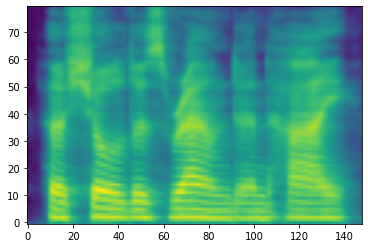

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: how loudly they cry on the hook for the reaping of men doomed to die


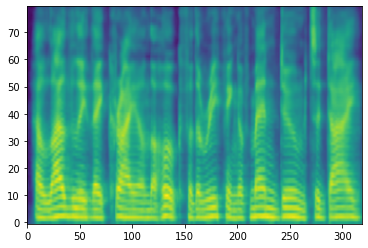

In [20]:
# Only need to set speaker_id if there is more than one speaker
speaker_id = None
if mixing:
    speaker_id = 1

num_val = 2  # Number of validation samples
val_records = []
with open(f"{new_speaker_id}_manifest_dev_ns_all_local.json", "r") as f:
    for i, line in enumerate(f):
        val_records.append(json.loads(line))
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker=speaker_id)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()

From the synthesized samples, there might be audible audio crackling. To fix this, we need to finetune HiFi-GAN on the new speaker's data. HiFi-GAN shows improvement using synthesized mel spectrograms, so the first step is to generate mel spectrograms with our finetuned FastPitch model to use as input.

In [21]:
import json
import numpy as np
import torch
import soundfile as sf

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator


In [23]:
import librosa

In [24]:
def load_wav(audio_file, target_sr=None):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
        sample_rate = f.samplerate
        if target_sr is not None and target_sr != sample_rate:
            samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
    return samples.transpose()

In [25]:
# Get records from the training manifest
manifest_path = "./6097_manifest_train_dur_5_mins_local.json"
records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

beta_binomial_interpolator = BetaBinomialInterpolator()
spec_model.eval()

device = spec_model.device

save_dir = Path("./6097_manifest_train_dur_5_mins_local_mels")
save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

hifigan_manifest_path = "hifigan_train_ft.json"
with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')

[NeMo W 2022-06-07 12:56:00 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
      warnings.warn(problem)
    


In [26]:
# Get records from the training manifest
manifest_path_validation = "./6097_manifest_dev_ns_all_local.json"
records_val = []
with open(manifest_path_validation, "r") as f:
    for i, line in enumerate(f):
        records_val.append(json.loads(line))

save_dir_val = Path("./6097_manifest_dev_ns_all_local_mels")
save_dir_val.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records_val):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path_val = save_dir_val / f"mel_{i}.npy"
        np.save(save_path_val, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path_val)

hifigan_val_manifest_path = "hifigan_val_ft.json"
with open(hifigan_val_manifest_path, "w") as f:
    for r in records_val:
        f.write(json.dumps(r) + '\n')

In [27]:
! mv hifigan.zip -t ./conf/
! cd conf && unzip hifigan.zip
! cd conf && cd hifigan && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml && cd .. && cd ..

Archive:  hifigan.zip
   creating: hifigan/
   creating: hifigan/model/
   creating: hifigan/model/validation_ds/
 extracting: hifigan/model/validation_ds/val_ds.yaml  
 extracting: hifigan/model/validation_ds/val_ds_finetune.yaml  
   creating: hifigan/model/train_ds/
 extracting: hifigan/model/train_ds/train_ds.yaml  
 extracting: hifigan/model/train_ds/train_ds_finetune.yaml  
   creating: hifigan/model/generator/
 extracting: hifigan/model/generator/v1.yaml  
 extracting: hifigan/model/generator/v1_44100.yaml  
 extracting: hifigan/model/generator/v2.yaml  
 extracting: hifigan/model/generator/v3.yaml  
 extracting: hifigan/hifigan.yaml    
 extracting: hifigan/hifigan_44100.yaml  
--2022-06-07 13:04:40--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/conf/hifigan/hifigan.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com

In [29]:
!wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/hifigan_finetune.py

--2022-06-07 13:09:36--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/hifigan_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1192 (1.2K) [text/plain]
Saving to: ‘hifigan_finetune.py’

hifigan_finetune.py 100%[===================>]   1.16K  --.-KB/s    in 0s      

2022-06-07 13:09:36 (81.8 MB/s) - ‘hifigan_finetune.py’ saved [1192/1192]



In [35]:
vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-06-07 13:24:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-06-07 13:24:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-06-07 13:24:44 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-06-07 13:24:48 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-06-07 13:24:48 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-06-07 13:24:48 features:259] PADDING: 0
[NeMo I 2022-06-07 13:24:48 features:276] STFT using torch


[NeMo W 2022-06-07 13:24:48 features:234] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-06-07 13:24:48 features:259] PADDING: 0
[NeMo I 2022-06-07 13:24:48 features:276] STFT using torch
[NeMo I 2022-06-07 13:24:49 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [37]:
!cp /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo .

In [43]:
!(python hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=32 \
model.max_steps=1000 \
model.optim.lr=0.0001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_val_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_nemo_model=tts_hifigan.nemo \
trainer.check_val_every_n_epoch=10 \
)

[NeMo W 2022-06-07 13:32:30 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-07 13:32:31 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-06-07 13:32:31 exp_manager:281] Experiments will be 

In [ ]:
\
#model.train_ds=/content/6097_manifest_dev_ns_all_local_mels \
#model.validation_ds=/content/6097_manifest_dev_ns_all_local_mels \


In [ ]:
# Get records from the training manifest
manifest_path = "./6097_manifest_train_dur_5_mins_local.json"
records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

In [ ]:
# Get records from the val manifest
manifest_path_val = "./6097_manifest_dev_ns_all_local.json"
records2 = []
with open(manifest_path_val, "r") as f:
    for i, line in enumerate(f):
        records2.append(json.loads(line))

In [ ]:
beta_binomial_interpolator = BetaBinomialInterpolator()
spec_model.eval()

device = spec_model.device

In [ ]:
save_dir = Path("./6097_manifest_train_dur_5_mins_local_mels")
save_dir.mkdir(exist_ok=True, parents=True)

save_dir2 = Path("./6097_manifest_dev_ns_all_local_mels")
save_dir2.mkdir(exist_ok=True, parents=True)

In [ ]:
# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

[NeMo W 2022-06-03 20:14:02 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
      warnings.warn(problem)
    


In [ ]:
# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records2):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir2 / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

In [ ]:
hifigan_manifest_path = "hifigan_train_ft.json"
with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')

In [ ]:
hifigan_manifest_path2 = "hifigan_dev_ft.json"
with open(hifigan_manifest_path2, "w") as f:
    for r in records2:
        f.write(json.dumps(r) + '\n')

In [ ]:
!wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/hifigan_finetune.py

--2022-06-03 20:20:53--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/hifigan_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1192 (1.2K) [text/plain]
Saving to: ‘hifigan_finetune.py’

hifigan_finetune.py 100%[===================>]   1.16K  --.-KB/s    in 0s      

2022-06-03 20:20:53 (45.1 MB/s) - ‘hifigan_finetune.py’ saved [1192/1192]



In [ ]:
! cd conf \
&& mkdir hifigan && cd hifigan && \
wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml \
&& cd .. && cd ..

--2022-06-03 20:24:43--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/conf/hifigan/hifigan.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2226 (2.2K) [text/plain]
Saving to: ‘hifigan.yaml’

hifigan.yaml        100%[===================>]   2.17K  --.-KB/s    in 0.001s  

2022-06-03 20:24:43 (2.66 MB/s) - ‘hifigan.yaml’ saved [2226/2226]



In [ ]:
!(python hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=32 \
model.max_steps=1000 \
model.optim.lr=0.0001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_dev_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_nemo_model=tts_hifigan.nemo \
trainer.check_val_every_n_epoch=10 \
model.train_ds=hifigan_train_ft.json \
model.validation_ds=hifigan_dev_ft.json)

[NeMo W 2022-06-03 20:25:15 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-03 20:25:15 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
In 'hifigan.yaml': Could not find 'model/validation_ds/val_ds'

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/drive/MyDrive/TTS-Finetuning-ConvAI/conf/hifigan
	